In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 線形回帰スクラッチ

In [354]:
class ScratchLinearRegression():
    """
    線形回帰のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    no_bias : bool
      バイアス項を入れない場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ
    self.loss : 次の形のndarray, shape (self.iter,)
      訓練データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証データに対する損失の記録

    """
    def __init__(self, num_iter=50, lr=0.01, no_bias=False, verbose=False, debug=False):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.no_bias = no_bias
        self.verbose = verbose
        
        #自分デバッグ用
        self.debug = debug
        self.test_data = np.array([0.0212, 0.0251, 0.555])  #検証用のテストデータ
        
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)
    
    def _data_processing(self, X, y=None):
        
        # データセットがDataFrame, Seriesの場合ndarrayに変換する
        if isinstance(X, (pd.DataFrame, pd.Series)):
            X = X.values
        if isinstance(y, (pd.DataFrame, pd.Series)):
            y = y.values
        
        # データセットが1次元の場合、2次元に変換する
        if X.shape[0] == X.size:
            X = X.reshape(-1, 1)
        
        if y is not None:
            y = y.reshape(-1, 1)

        # 特徴量のサンプル数をセット
        m = X.shape[0]
        
        # バイアス項の追加
        if self.no_bias:
            n = X.shape[1]
        else:
            n = X.shape[1] + 1
            # Xに切片の(x=1)を追加
            X = np.concatenate((np.ones((m, 1)), X), axis=1)

        return X, y
        
    def fit(self, X, y, X_val=None, y_val=None):
        """
        線形回帰を学習する。検証データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        # 検証データの計算を行うかどうか
        is_val_calc = (X_val is not None) and (y_val is not None)
        
        # データ前処理
        X, y  = self._data_processing(X, y)
        if is_val_calc:
            X_val, y_val  = self._data_processing(X_val, y_val)
        
        #パラメータθを特徴量数に合わせて作成
        if self.debug:
            self.coef_ = self.test_data
        else:
            self.coef_ = np.array(np.random.rand(X.shape[1]))
        
        # イテレータ数,学習を繰り返す
        for i in range(self.iter):
            self._gradient_descent(X, y, alpha=self.lr)
            self.loss[i] = self._loss(X, y)
            
            # 検証データが渡されたときは、検証データでの損失関数値を記録する
            if is_val_calc:
                self.val_loss[i] = self._loss(X_val, y_val)
            
            if self.verbose:
                #verboseをTrueにした際は学習過程を出力
                print("|train| iter: {}  coef:{}".format(i+1, self.coef_))
        
    def predict(self, X):
        """
        線形回帰を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            線形回帰による推定結果
        """
        
        X, _ = self._data_processing(X)
        theta = self.coef_.reshape(1, -1)
        
        pred = np.sum(X @ theta.T, axis=1).reshape(-1, 1)
        
        return pred
    
    def _linear_hypothesis(self, X):
        """
        線形の仮定関数を計算する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          訓練データ

        Returns
        -------
          次の形のndarray, shape (n_samples, 1)
          線形の仮定関数による推定結果

        """
        #仮説関数を定式化
        h_theta = np.sum(self.coef_* X, axis=1).reshape(-1, 1)
        return h_theta
 
    def _error(self, X, y):
        """
        予測値と実際値の誤差を計算する関数

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          訓練データ
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        
        Returns
        -------
          次の形のndarray, shape (n_samples, 1)
          予測値と実際値の誤差

        """
        return self._linear_hypothesis(X) - y
    
    def _gradient_descent(self, X, y, alpha):
        """
        パラメータθを勾配方向に更新する
        
         Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          訓練データ
        y : 次の形のndarray, shape (n_samples, )
          訓練データの正解値

        """
        
        grad = np.average(self._error(X, y) * X, axis=0)
        self.coef_ = self.coef_ - alpha * grad

    def _loss(self, X, y):
        """
        損失関数を計算する

         Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          訓練データ
        y : 次の形のndarray, shape (n_samples, )
          訓練データの正解値

        """
        loss =  0.5 * np.average(self._error(X, y) ** 2)
        return loss
        

## 【問題1】仮定関数
以下の数式で表される線形回帰の仮定関数を実装してください。メソッドの雛形を用意してあります。

$h_θ(x) = θ_0x_0+θ_1x_1+θ_2x_2･･･θ_nx_n.(x_0=1)$


$x$ : 特徴量ベクトル


$\theta$ : パラメータベクトル


$n$ : 特徴量の数


$x_j$ : j番目の特徴量


$\theta_j$ : j番目のパラメータ（重み）


## 【問題2】最急降下法
最急降下法により学習させる実装を行なってください。

以下の式で表されるパラメータの更新式のメソッド_gradient_descentを追加し、fit
メソッドから呼び出すようにしてください。

$\theta_j := \theta_j - \alpha \frac{1}{m} \sum_{i=1}^{m}[(h_\theta(x^{(i)}) - y^{(i)} )x_{j}^{(i)}]$



$\alpha$ : 学習率

$i$ : サンプルのインデックス

$j$ : 特徴量のインデックス

## 【問題3】推定
推定する仕組みを実装してください。ScratchLinearRegressionクラスの雛形に含まれるpredictメソッドに書き加えてください。

仮定関数 $h_\theta(x)$ の出力が推定結果です。

## 【問題4】平均二乗誤差
線形回帰の指標値として用いられる平均二乗誤差（mean square error, MSE）の関数を作成してください。

平均二乗誤差関数は回帰問題全般で使える関数のため、ScratchLinearRegressionクラスのメソッドではなく、別の関数として作成してください。

平均二乗誤差は以下の数式で表されます。

$J(\theta)=  \frac{1 }{ m}  \sum_{i=1}^{m} (h_\theta(x^{(i)})-y^{(i)})^2.$

$h_\theta()$ : 仮定関数

$x^{(i)}$ : i番目のサンプルの特徴量ベクトル

$y^{(i)}$ : i番目のサンプルの正解値

なお、最急降下法のための目的関数（損失関数）としては、これを2で割ったものを使用します。（問題5, 9）

## 【検証１～４】 

クラスの実装はすべてまとめて2段目に記載する。

以降の処理はクラス実装が問題なく行えているか検証したもの。エクセルで計算した理論値と一致するかを確認する。

検証に用いる、数字・特徴量の条件は以下のとおり。説明変数は2個、サンプル数は3個として考える

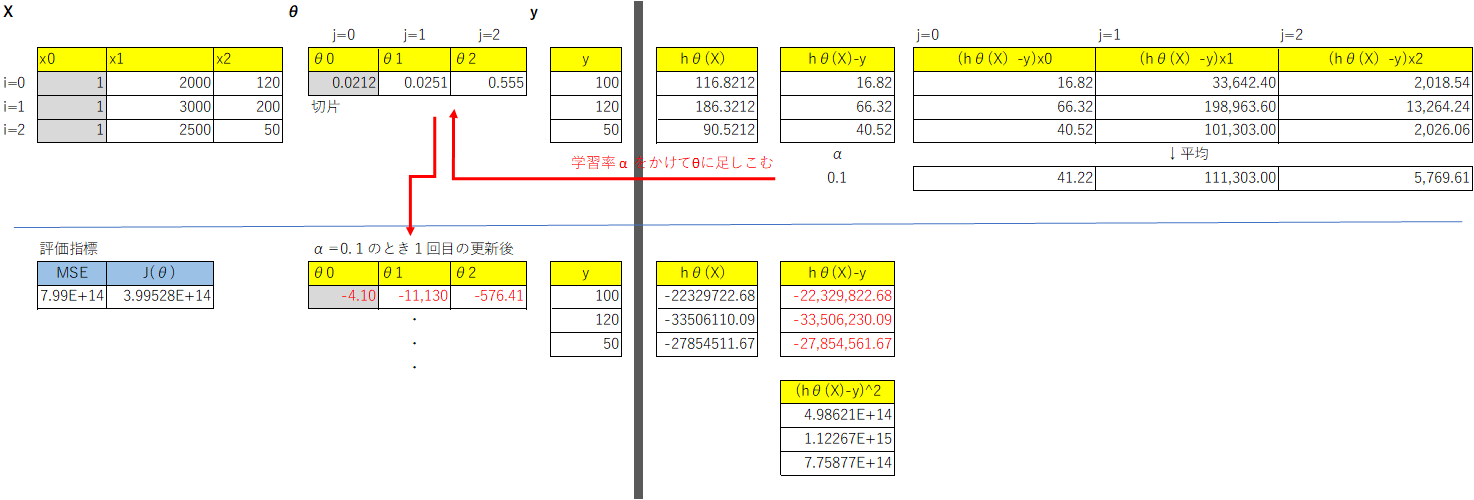

In [338]:
# テストデータ
X = np.array([[2000, 120], [3000, 200], [2500, 50]])
y = np.array([100, 120, 50])
alpha = 0.1

print("X:\n", X)
print("y:\n", y)

lr = ScratchLinearRegression(num_iter=1, lr=alpha ,verbose=True, debug=True) #デバッグモードTrue


X:
 [[2000  120]
 [3000  200]
 [2500   50]]
y:
 [100 120  50]


In [339]:
np.set_printoptions(suppress=True, precision=3)
lr.fit(X, y)

|train| iter: 1  coef:[    -4.101 -11130.275   -576.406]


In [340]:
pred = lr.predict(X)
print("一度だけ学習を行った後の予測値：\n", pred)

一度だけ学習を行った後の予測値：
 [[-22329722.677]
 [-33506110.094]
 [-27854511.674]]


In [341]:
def MSE(y_pred, y):
    """
    平均二乗誤差の計算

    Parameters
    ----------
    y_pred : 次の形のndarray, shape (n_samples,)
      推定した値
    y : 次の形のndarray, shape (n_samples,)
      正解値

    Returns
    ----------
    mse : numpy.float
      平均二乗誤差
    """

    if len(y_pred) != len(y):
        raise Exception("要素が不一致")

    if isinstance(y_pred, (pd.DataFrame, pd.Series)):
        y_pred = y_pred.values
    
    if isinstance(y, (pd.DataFrame, pd.Series)):
        y = y.values
        
    #計算前に形状加工
    m = len(y_pred)
    y_pred =  y_pred.reshape(-1,1)
    y = y.reshape(-1, 1)
    
    mse = np.average((y_pred - y)**2)
    
    return mse

In [342]:
mse = MSE(pred, y)
print("MSE:", mse)
print("objective:", lr.loss)

MSE: 799055013992173.6
objective: [3.995e+14]


理論値とすべて同じ値になったため実装は問題なさそう

## 【問題5】目的関数
以下の数式で表される線形回帰の 目的関数（損失関数） を実装してください。

そして、これをself.loss, self.val_lossに記録するようにしてください。


目的関数（損失関数） $J(\theta)$ は次の式です。

$J(\theta)=  \frac{1 }{ 2m}  \sum_{i=1}^{m} (h_\theta(x^{(i)})-y^{(i)})^2.$

$m$ : 入力されるデータの数

$h_\theta()$ : 仮定関数


$x^{(i)}$ : i番目のサンプルの特徴量ベクトル


$y^{(i)}$ : i番目のサンプルの正解値

## 【問題6】学習と推定
機械学習スクラッチ入門のSprintで用意したHouse Pricesコンペティションのデータに対してスクラッチ実装の学習と推定を行なってください。

scikit-learnによる実装と比べ、正しく動いているかを確認してください。

In [378]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

#データの読み込み
train = pd.read_csv("train.csv")
train_x = train[["GrLivArea", "YearBuilt"]]
train_y = train["SalePrice"]

#訓練データを分割
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, random_state=1)

#標準化
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

#sklearnとスクラッチとのモデル比較
sklearn_lr = LinearRegression()
scrach_lr  = ScratchLinearRegression(num_iter=5000, lr=0.001)

model = {"sklearn_LinearRegression": sklearn_lr, "scrach_LinearRegression": scrach_lr}

#結果比較用のdfを作成
results = pd.DataFrame(columns=["model", "sklearn_mse", "scratch_mse"], index=list(range(len(model))))
i = 0

for name, model in model.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    sklearn_mse = mean_squared_error(y_pred, y_test)
    scratch_mse = MSE(y_pred, y_test)
    results.loc[i, :] = [name, sklearn_mse, scratch_mse]
    i += 1

display(results)
    

,model,sklearn_mse,scratch_mse
0,sklearn_LinearRegression,1.88679e+09,1.88679e+09
1,scrach_LinearRegression,4.81278e+09,4.81278e+09


**結果**  
sklearnと同じ結果にはならず...  
学習率やイテレータ、正則化項などのハイパーパラメータ値の違いによるものか

## 【問題7】学習曲線のプロット
学習曲線を表示する関数を作成し、実行してください。グラフを見て損失が適切に下がっているかどうか確認してください。

線形回帰クラスの雛形ではself.loss, self.val_lossに損失を記録しておくようになっているため、入力にはこれを利用してください

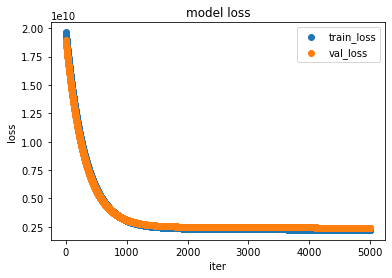

coef: [103273.357  46743.387  98471.111]
MSE: 4812787993.357906


In [379]:
# 検証データ込みで学習を行う
scrach_val_lr = ScratchLinearRegression(num_iter=5000, lr=0.001)
scrach_val_lr.fit(X_train, y_train, X_test, y_test)
y_pred = scrach_val_lr.predict(X_test)
mse = MSE(y_pred, y_test)

iter_list = list(range(scrach_val_lr.iter))
loss_list = scrach_val_lr.loss
val_loss_list = scrach_val_lr.val_loss

# 学習曲線を可視化
plt.scatter(iter_list, loss_list, label="train_loss")
plt.scatter(iter_list, val_loss_list, label="val_loss")

plt.xlabel("iter")
plt.ylabel("loss")
plt.title("model loss")
plt.legend()
plt.show()

print("coef:", scrach_val_lr.coef_)
print("MSE:", mse)


## 【問題8】（アドバンス課題）バイアス項の除去
バイアス項 $\theta_0$ を抜くと学習がどう変化するか検証してください。

また、線形回帰モデルにおけるバイアス項の役割の考察・調査を行ってください。

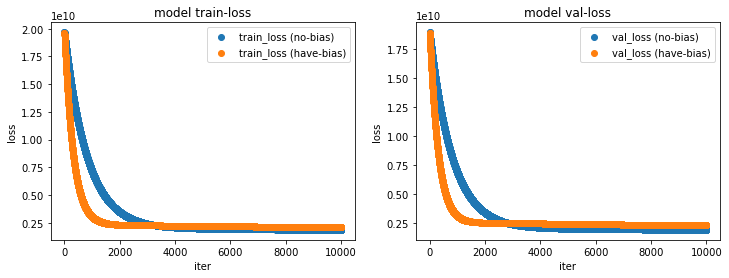

infomation have-bias:
coef: [ 91583.804  66146.975 108339.854]

infomation no-bias:
coef: [107369.314 217143.161]


In [380]:
num_iter = 10000
alpha = 0.001

# バイアス項なしで学習を行う
scrach_no_bias_lr = ScratchLinearRegression(num_iter=num_iter, lr=alpha, no_bias=True, verbose=False)
scrach_no_bias_lr.fit(X_train, y_train, X_test, y_test)

# バイアス項ありで学習を行う
scrach_have_bias_lr = ScratchLinearRegression(num_iter=num_iter, lr=alpha, verbose=False)
scrach_have_bias_lr.fit(X_train, y_train, X_test, y_test)

# 各モデルにおけるコスト関数の値を取り出す
iter_list = list(range(scrach_no_bias_lr.iter))

no_bias_loss_list = scrach_no_bias_lr.loss
no_bias_val_loss_list = scrach_no_bias_lr.val_loss

have_bias_loss_list  = scrach_have_bias_lr.loss
have_bias_val_loss_list  = scrach_have_bias_lr.val_loss

# 学習曲線を可視化
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.scatter(iter_list, no_bias_loss_list, label="train_loss (no-bias)")
ax1.scatter(iter_list, have_bias_loss_list, label="train_loss (have-bias)")

ax2.scatter(iter_list, no_bias_val_loss_list, label="val_loss (no-bias)")
ax2.scatter(iter_list, have_bias_val_loss_list, label="val_loss (have-bias)")

ax1.set_xlabel("iter")
ax1.set_ylabel("loss")
ax1.set_title("model train-loss")

ax2.set_xlabel("iter")
ax2.set_ylabel("loss")
ax2.set_title("model val-loss")

ax1.legend()
ax2.legend()
plt.show()

print("infomation have-bias:")
print("coef:", scrach_have_bias_lr.coef_)
print()
print("infomation no-bias:")
print("coef:", scrach_no_bias_lr.coef_)


**<u>結果・考察</u>**

バイアス項を除去すると原点を通る線形式に回帰することを意味する。  
つまり、特徴量が全て０のとき、目的変数の値も０に回帰される。  

検証結果より、バイアス項を除去したモデルは、そうでないモデルと比較して学習スピードが緩やかになる。  
しかし、学習の回数を重ねると、バイアス項のあるモデルより、精度の高いモデルが出来上がった。  
(学習回数3,500回付近でバイアス項ありのモデルより評価関数の結果が良くなっている）

今回、特徴量に用いた変数は「住宅のリビング面積」と「築年数」。  
変数「住宅のリビング面積」の性質に着目すると、値０は住宅として全く価値のないことを意味し、  
その場合、目的変数「住宅価格」も０になることが予想される。

そのため、バイアス項を除去した原点を通る線形回帰モデルの方が、より精度の高い結果となったと考えられる。

## 【問題9】（アドバンス課題）特徴量の多次元化
特徴量の二乗や三乗を入力に利用すると学習結果がどう変化するか検証してください。

**まずは特徴量1つのみで検証**

In [381]:
train_x1 = train["GrLivArea"]
train_x2 = train["GrLivArea"]**2
train_x3 = train["GrLivArea"]**3
train_y = train["SalePrice"]

data = {"feature x": train_x1, "feature x^2": train_x2, "feature x^3": train_x3}

for name, tr in data.items():
    X_train, X_test, y_train, y_test = train_test_split(tr, train_y, random_state=1)
    X_train, X_test, y_train, y_test = map(np.array, (X_train, X_test, y_train, y_test))
    
    X_train = X_train.reshape(-1, 1)
    X_test  = X_test.reshape(-1, 1)
    
    #スケーリング
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test  = scaler.transform(X_test)
    
    lr = ScratchLinearRegression(num_iter=5000, lr=0.001)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    mse = MSE(y_pred, y_test)
    
    results.loc[i, :] = [name, np.nan, mse]
    i += 1


特徴量を2つに増やして検証

In [382]:
train_x1 = train[["GrLivArea", "YearBuilt"]]
train_x2 = train[["GrLivArea", "YearBuilt"]]**2
train_x3 = train[["GrLivArea", "YearBuilt"]]**3
train_y = train["SalePrice"]

data = {"two features x": train_x1, "two features x^2": train_x2, "two features x^3": train_x3}

for name, tr in data.items():
    X_train, X_test, y_train, y_test = train_test_split(tr, train_y, random_state=1)
    X_train, X_test, y_train, y_test = map(np.array, (X_train, X_test, y_train, y_test))
    
    #スケーリング
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test  = scaler.transform(X_test)
    
    lr = ScratchLinearRegression(num_iter=5000, lr=0.001)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    mse = MSE(y_pred, y_test)
    
    results.loc[i, :] = [name, np.nan, mse]
    i += 1


In [383]:
results

,model,sklearn_mse,scratch_mse
0,sklearn_LinearRegression,1.88679e+09,1.88679e+09
1,scrach_LinearRegression,4.81278e+09,4.81278e+09
2,feature x,NaN,6.01664e+09
3,feature x^2,NaN,6.50498e+09
4,feature x^3,NaN,6.67151e+09
5,two features x,NaN,4.81279e+09
6,two features x^2,NaN,5.08494e+09
7,two features x^3,NaN,5.17889e+09


**<u>結果</u>**

二乗や三乗を特徴量の入力に使用した場合、そうでない場合と比較して、精度が落ちた。

## 【問題10】（アドバンス課題）更新式の導出
最急降下法の更新式は以下でした。この式が導出される過程を説明してください。

$\theta_j := \theta_j - \alpha \frac{1}{m} \sum_{i=1}^{m}[(h_\theta(x^{(i)}) - y^{(i)} )x_{j}^{(i)}]$

以下の式から説明をはじめることができます。

$\theta_j := \theta_j - \frac{\partial}{\partial \theta_j}J(\theta) \$

目的関数（損失関数） $J(\theta)$ は次の式です。

$J(\theta)=  \frac{1 }{ 2m}  \sum_{i=1}^{m} (h_\theta(x^{(i)})-y^{(i)})^2.$

**【解答】**

線形回帰の指標値として用いられる平均二乗誤差の関数は次の式①で求まる。

$J(\theta)=  \frac{1 }{ 2m}  \sum_{i=1}^{m} (h_\theta(x^{(i)})-y^{(i)})^2.$ 　…①

①を微分すると得られる②の式は、点θにおける勾配を意味する。

$ \frac{1}{m} \sum_{i=1}^{m}[(h_\theta(x^{(i)}) - y^{(i)} )x_{j}^{(i)}]$   …②

①が極値をとるときのθは、②の式が０になる点θとなる。

変数が多い場合、②＝０の式を解くのは計算コストが高いため、ランダムにθを選択しその点における勾配を、元のθから減算すれば極値に近づくことになる。以上のことを計算式で表現すると次の式③となる。

$\theta := \theta - \alpha \frac{1}{m} \sum_{i=1}^{m}[(h_\theta(x^{(i)}) - y^{(i)} )x^{(i)}]$ …③

③の式を各パラメータθに対して繰り返すので

$\theta_j := \theta_j - \alpha \frac{1}{m} \sum_{i=1}^{m}[(h_\theta(x^{(i)}) - y^{(i)} )x_{j}^{(i)}]$ …（Ans）


## 【問題11】（アドバンス課題）局所最適解の問題
最急降下法には一般的に局所最適解の問題があります。

しかし、線形回帰では学習を続ければ必ず最適解を求めることができます。

それはなぜか数式やグラフを用いて説明してください。

**【解答】**

線形回帰の仮定関数は以下の式で定義される。

$h_\theta(x) =  \theta_0 x_0 + \theta_1 x_1 + ... + \theta_j x_j + ... +\theta_n x_n.   (x_0 = 1)$ ---①

仮定関数①はn次元の変数$\theta_j$の関数であるが、$\theta$の次数はすべて１である。

また、目的関数である$J(\theta)$は仮定関数①の二乗の関数である。

$J(\theta)=  \frac{1 }{ 2m}  \sum_{i=1}^{m} (h_\theta(x^{(i)})-y^{(i)})^2.$　---②

②は$\theta$の２次方程式となるため、各$\theta$における極値は１点しか持たない。

そのため、すべてのθにおいて偏微分を行うことで、$J(\theta)$が最小となる極小点が必ず１つ求まる

つまり、局所的最適解に陥ることはない。

